# Validation
Three goals:

 - Check where the reads of our target studies (Crits-Christoph, Rothman, Spurbeck, and Brinch) end up.

 - Check if there is some bias in which viral species have worse or better scores. Understanding the makeup of the left side of the distribution but got bogged down by results that couldn’t be right. I will pick up on this tomorrow, though I will first work on point 1 as that seems more important.
 - Cross-check BowTie2 results with Jeff’s original validation results.

In [1]:
import os
import json
import matplotlib.pyplot as plt
from math import sqrt
from collections import Counter
import numpy as np
import pandas as pd

In [2]:
dashboard = os.path.expanduser("~/code/mgs-pipeline/dashboard/")

with open(os.path.join(dashboard, "human_virus_sample_counts.json")) as inf:
    human_virus_sample_counts = json.load(inf)

with open(os.path.join(dashboard, "metadata_samples.json")) as inf:
    metadata_samples = json.load(inf)

with open(os.path.join(dashboard, "metadata_bioprojects.json")) as inf:
    metadata_bioprojects = json.load(inf)

with open(os.path.join(dashboard, "metadata_papers.json")) as inf:
    metadata_papers = json.load(inf)

with open(os.path.join(dashboard, "taxonomic_names.json")) as inf:
    taxonomic_names = json.load(inf)


studies = list(metadata_papers.keys())

In [61]:
# metadata_samples["SRR23083823"]
metadata_samples["SRR23083780"]

{'country': 'United States',
 'county': 'Montgomery County',
 'date': '2022-01-02',
 'enrichment': 'viral',
 'fine_location': 'J',
 'location': 'Ohio',
 'method': 'IJ',
 'reads': 6390165,
 'state': 'Ohio'}

In [3]:
# count lines in all sam files that do not start with @

sam_entries = 0

for filename in os.listdir('hvsams'):
    if filename.endswith(".sam"):
        with open('hvsams/'+filename) as f:
            for line in f:
                if not line.startswith('@'):
                    sam_entries += 1

# count entries in hvreads.json
fastq_read_entries = 0
for filename in os.listdir('hvreads'):
    with open(f'hvreads/{filename}') as f:
        hvreads = json.load(f)
        fastq_read_entries += len(hvreads)

print(fastq_read_entries, sam_entries)


KeyboardInterrupt: 

## Understanding overall alignment score quality distribution

In [4]:
refseq_directory_path = "raw-genomes"

refseq_id_and_names = {}

for filename in os.listdir(refseq_directory_path):
    with open(os.path.join(refseq_directory_path, filename)) as inf:
        for line in inf:
            if line.startswith(">"):
                identifier, description = line[1:].split(" ", 1)
                identifier = str(identifier.strip())
                name = description.split(",", 1)[0]
                refseq_id_and_names[identifier] = name.strip()
            else:
                continue

In [5]:
sam_records = []

hvsams_directory_path = "hvsams"


for filename in os.listdir(hvsams_directory_path):
    if filename.endswith(".sam"):
        with open(hvsams_directory_path + "/" + filename) as inf:
            for line in inf:
                if line.startswith("@"):
                    continue
                else:
                    line_split = line.split("\t")
                     
                    read_id = line_split[0]
                    sample_id = read_id.split(".")[0]
                    if  "_" in sample_id:
                        sample_id = sample_id.split("_", 1)[1]

                    
                    reference_sequence = str(line_split[2])
                    reference_name = refseq_id_and_names.get(reference_sequence, "No Alignment")
                    if reference_sequence == "*":
                        alignment_score = 0 # no aligment found
                        sam_records.append([read_id, alignment_score, sample_id, reference_sequence, reference_name])
                        continue
                
                    read_length = len(line_split[9])

                    optional_fields_dict = {}
                    for field in line_split[11:]:
                        key, _, value = field.split(":")
                        optional_fields_dict[key] = value

                    if "AS" in optional_fields_dict:
                        alignment_score = int(optional_fields_dict["AS"])
                        length_adjusted_alignment_score = alignment_score / sqrt(read_length)
                        sam_records.append([read_id, length_adjusted_alignment_score, sample_id, reference_sequence,  reference_name])

                    else: # no aligment performed
                        alignment_score = 0
                        sam_records.append([read_id, alignment_score, sample_id, reference_sequence, reference_name])
                        continue

In [49]:
[x for x in sam_records if x[0] == "SRR13711891.4013"]

[['SRR13711891.4013',
  23.669528414027724,
  'SRR13711891',
  'NC_001474.2',
  'Dengue virus 2'],
 ['SRR13711891.4013',
  4.5518323873130235,
  'SRR13711891',
  'NC_001474.2',
  'Dengue virus 2']]

In [6]:
df = pd.DataFrame(sam_records, columns=["read_id", "alignment_score", "sample_id", "reference_sequence", "reference_name"])

In [8]:
print(df.head())

               read_id  alignment_score   sample_id reference_sequence   
0  ERR4682442.12860147         0.000000  ERR4682442                  *  \
1  ERR4682442.12860147         0.000000  ERR4682442                  *   
2  ERR4682442.13005367         0.000000  ERR4682442                  *   
3  ERR4682442.13005367         0.000000  ERR4682442                  *   
4  ERR4682442.13010616        21.147261  ERR4682442        NC_001454.1   

       reference_name  
0        No Alignment  
1        No Alignment  
2        No Alignment  
3        No Alignment  
4  Human adenovirus F  


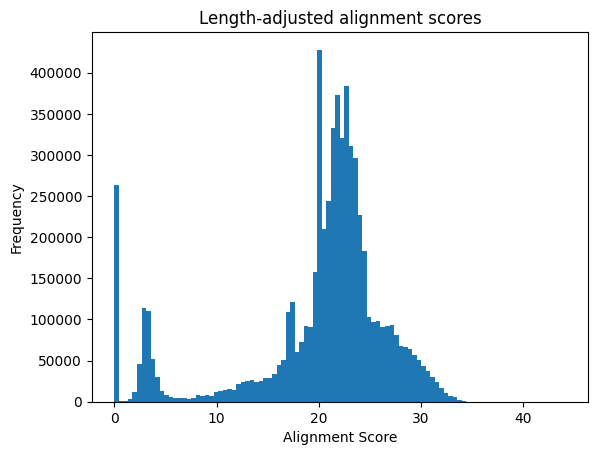

<Figure size 640x480 with 0 Axes>

In [7]:
plt.hist(df["alignment_score"], bins=100)
plt.title("Length-adjusted alignment scores")
plt.xlabel("Alignment Score")
plt.ylabel("Frequency")
plt.show()
plt.clf()

# adapt code to plot alignment scores as a histogram


In [16]:
alignment_score_5_sub_sample = df[df["alignment_score"].round() == 5].sample(n=20, random_state=1)

# get shape of alignment_score_5_sub_sample
print(alignment_score_5_sub_sample)


alignment_score_10_sub_sample = df[df["alignment_score"].round() == 10].sample(n=20, random_state=1)

print(alignment_score_10_sub_sample)

                       read_id  alignment_score    sample_id   
5100785   SRR12204734.95316656         4.735680  SRR12204734  \
1175060       SRR13711891.4013         4.551832  SRR13711891   
1274341      SRR14530833.22865         5.373201  SRR14530833   
2749034    ERR4682430.20545472         5.126867   ERR4682430   
1673872  M_ERR4678607.24608978         4.611946   ERR4678607   
1699432     ERR2683277.8314686         5.225578   ERR2683277   
3203521  SRR12204851.141885562         4.735680  SRR12204851   
341015      SRR14530845.849711         4.676675  SRR14530845   
4244513     SRR8749024.1225113         5.074690   SRR8749024   
5828120    ERR4682844.31683125         4.638594   ERR4682844   
5888194    ERR2683146.33466070         4.898979   ERR2683146   
3571125     SRR23800659.646182         5.045488  SRR23800659   
654931     ERR2607510.14239343         5.208246   ERR2607510   
2953454   SRR12204850.47867557         5.045488  SRR12204850   
4062557   SRR12204849.77422202         5

In [48]:
# take the read id. split it in two. search the file SRR12204734.combined.fastq in the hvfastqs directory for the read id. Return the row below the row that matches the read id. Return the sequence from that row.


def search_fastq(entry):
        file_id, read_id = entry.split(".")
        if "_" in file_id:
            file_id = file_id.split("_", 1)[1]
        with open(f'hvfastqs/{file_id}.combined.fastq') as f1:
            for line in f1:
                if read_id in line:
                    return entry, file_id, "combined", next(f1).strip()
        with open(f'hvfastqs/{file_id}.pair1.fastq') as f2, open(f'hvfastqs/{file_id}.pair2.fastq') as f3:
            for line2, line3 in zip(f2, f3):
                if read_id in line2:
                    return entry, file_id, "paired", str(next(f2).strip()), str(next(f3).strip())

score_5_sequences = []

for entry in alignment_score_5_sub_sample["read_id"]:
    result = search_fastq(entry)
    if result is not None:
        score_5_sequences.append(result)
        if result[2] == "combined":
            print(entry, result[3])
        else:
            print(entry, "read_1", result[3], "read_2", result[4])


    


    

SRR12204734.95316656 read_1 CTTGGCATAAGAGTAGATTTTTGTACAACCTTACCTGTACTGTCTTTTATTTCAACAACAGATGAAGAAGCAGCTGGTAGACACGTATAAATACGTACCACAGCAGCCATAATAGCAATGGCTGTAGTATGTATGCCCATGGAGTCACAT read_2 CGTTTTATTATTAAAAAAAAAAAAAAAAAAATAATAAAAAAAAAAAAAAAAAAAAAAATAAAAAAAAAAAAAAATTATAATTTAATGTTGTTTTTTTTTAAATTTAAAAAAAAAAAAATTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
SRR13711891.4013 CCTTTTGAAGGTTCCCATTGTTGTATGTCTTTTCTAATCTTTCCCATGTCATTCAGAGCTGTCAAAGCGTTTGCGAACCTGTCATCTAAAGGTTTCACAACACAATCATCTCCACTGATGGCCATTCTTGACAACCTTTCGCGCCCCACTCTAGCCAACCAGTTTTGCACAGCAGCTTCTTCTGTGACTGTCAGATGCTGGATGTTTTTAAAGACTCCTTCTCCTTCCATCTGTCTGATTAATTGAGCTTCC
SRR14530833.22865 TGTTTTGTATGCGTCAATATGCTTATTCAGCAAAATGACTTGATCTTTGAAATTTGGATCTTTGTCATCCAATTTGATGGCACCTGTGT
ERR4682430.20545472 read_1 CCCTGGGGTGGAGGTAGGACCACTGGAGGGCGTCATGCTCGGGGGTGGTGTTGTAAATAATCCAATCGTAACAGGGTTTTTGGGCATGAAACTGAAATATGTCCTTAAGGAGCAGGCTAATGGCCAGGGGTAGTCCCTTGGTAAAAGTATT read_2 TCCCAGCTTATTAATCCTCCCCCCGAAACCGTTTTTTTCATCGGCCCCCAAGTGGACATGATTCCCCCAGCCGAAATTAGGGCGTGGGAGATGCAAAGT

In [47]:
def search_fastq(entry):
        file_id, read_id = entry.split(".")
        if "_" in file_id:
            file_id = file_id.split("_", 1)[1]
        with open(f'hvfastqs/{file_id}.combined.fastq') as f1:
            for line in f1:
                if read_id in line:
                    return entry, file_id, "combined", next(f1).strip()
        with open(f'hvfastqs/{file_id}.pair1.fastq') as f2, open(f'hvfastqs/{file_id}.pair2.fastq') as f3:
            for line2, line3 in zip(f2, f3):
                if read_id in line2:
                    return entry, file_id, "paired", str(next(f2).strip()), str(next(f3).strip())

score_10_sequences = []

for entry in alignment_score_10_sub_sample["read_id"]:
    result = search_fastq(entry)
    if result is not None:
        score_5_sequences.append(result)
        if result[2] == "combined":
            print(result[3])
        else:
            print("read_1", result[3], "read_2", result[4])



read_1 GCGTGATTTACAATCAAAAATAGGATCAGTCATTTCGTCCATTGAGTGGTACTTACGGTCTATGGAACTATCAGATGACATTAAATCAGATATTGAACAACAACTCAATTCAATAGATCATATTAATCCAGTTAACGCTTTTGACGATTTT read_2 GCCATTTAGGTTTTTGACAGTGTTAGCTTTTAACTATTGTGCTCATAGAGGGTTACGTGAAGATGGTAATATGCTATGTTTACTCATAGGTATAAGTATAATTACTTTGCTGCAACAATCCTTTAAACATAATAAAAATTCTATCATAATC
read_1 GCGTGATTTACAATCAAAAATAGGATCAGTCATTTCGTCCATTGAGTGGTACTTACGGTCTATGGAACTATCAGATGACATTAAGTCAGATATTGAACAACAACTCAATTCAATAGATCATATTAATCCAGTTAACGCTTTTGACGATTTT read_2 TAGCCATTTAGGTTTTTGACAGTGTTAGCTTTTAACTATTGTGCTCATAGAGGGTTCCGTGAAGATGGTAATATGCTATGTTTACTCATAGGTATAAGTATAATTACTTTGCTGCAACAATCCTTTAAACATAATAAAAATTCTATCATAA
read_1 ATTCACACAACGGGGATCATCACATACACTCAATGCCGTATTGACATCGGTCAGCCACTTCAGAGCGATACAATCTTCTGAAGGGCGTGCTAACAAGTCAGACACATAGGGGATACTCTTCAGAAGTTCCCAAACCCACATAATGGGTTT read_2 CTAAAAAGCACACAAAACCAAAGATTTTCGACAAATACCAAACAAAAACAAAAACCTCCACAAAAATGTGTAAAAACCTAAAAAACACAAAAATTTGATTTTTTAAAATAATAAAAAAATAAACAAATTTTATGAAAATTTATCACAACC
read_1 ACTCTGAACTCACTTTCCATCCAACTTTTGTTGTTTTTGTG

# Cross-checking BowTie2 alignments with Kraken assigments.

In [ ]:
# example SSR: SRR14530724 with bioproject PRJNA729801



In [89]:
brinch_samples = []
for study in studies:
    if study not in [
        "Brinch 2020",  # unpublished data
    ]:
        continue
    
    for bioproject in metadata_papers[study]["projects"]:
        samples = metadata_bioprojects[bioproject]

        # set all samples to strin type
        samples = [str(sample) for sample in samples]
        brinch_samples.extend(samples)


rothman_samples = []
for study in studies:
    if study not in [
        "Rothman 2021",  # unpublished data
    ]:
        continue
    
    for bioproject in metadata_papers[study]["projects"]:
        samples = metadata_bioprojects[bioproject]

        # set all samples to strin type
        samples = [str(sample) for sample in samples]
        rothman_samples.extend(samples)

print(rothman_samples)



spurbeck_samples = []
for study in studies:
    if study == "Spurbeck 2023":
        for bioproject in metadata_papers[study]["projects"]:
            samples = metadata_bioprojects[bioproject]

            # set all samples to strin type
            samples = [str(sample) for sample in samples]
            spurbeck_samples.extend(samples)


['SRR14530724', 'SRR14530725', 'SRR14530726', 'SRR14530727', 'SRR14530728', 'SRR14530729', 'SRR14530730', 'SRR14530731', 'SRR14530732', 'SRR14530733', 'SRR14530734', 'SRR14530735', 'SRR14530736', 'SRR14530737', 'SRR14530738', 'SRR14530739', 'SRR14530740', 'SRR14530741', 'SRR14530742', 'SRR14530743', 'SRR14530744', 'SRR14530745', 'SRR14530746', 'SRR14530747', 'SRR14530748', 'SRR14530749', 'SRR14530750', 'SRR14530751', 'SRR14530752', 'SRR14530753', 'SRR14530754', 'SRR14530755', 'SRR14530756', 'SRR14530757', 'SRR14530758', 'SRR14530759', 'SRR14530760', 'SRR14530761', 'SRR14530762', 'SRR14530763', 'SRR14530764', 'SRR14530765', 'SRR14530766', 'SRR14530767', 'SRR14530768', 'SRR14530769', 'SRR14530770', 'SRR14530771', 'SRR14530772', 'SRR14530773', 'SRR14530774', 'SRR14530775', 'SRR14530776', 'SRR14530777', 'SRR14530778', 'SRR14530779', 'SRR14530780', 'SRR14530781', 'SRR14530782', 'SRR14530783', 'SRR14530784', 'SRR14530785', 'SRR14530786', 'SRR14530787', 'SRR14530788', 'SRR14530789', 'SRR14530

In [74]:
print(spurbeck_samples)

['SRR23083716', 'SRR23083718', 'SRR23083720', 'SRR23083722', 'SRR23083725', 'SRR23083727', 'SRR23083729', 'SRR23083731', 'SRR23083733', 'SRR23083734', 'SRR23083736', 'SRR23083738', 'SRR23083740', 'SRR23083742', 'SRR23083744', 'SRR23083747', 'SRR23083749', 'SRR23083751', 'SRR23083753', 'SRR23083755', 'SRR23083756', 'SRR23083758', 'SRR23083760', 'SRR23083762', 'SRR23083764', 'SRR23083766', 'SRR23083769', 'SRR23083771', 'SRR23083773', 'SRR23083775', 'SRR23083778', 'SRR23083780', 'SRR23083782', 'SRR23083784', 'SRR23083786', 'SRR23083787', 'SRR23083789', 'SRR23083790', 'SRR23083792', 'SRR23083794', 'SRR23083795', 'SRR23083797', 'SRR23083798', 'SRR23083799', 'SRR23083801', 'SRR23083804', 'SRR23083806', 'SRR23083808', 'SRR23083810', 'SRR23083813', 'SRR23083818', 'SRR23083820', 'SRR23083822', 'SRR23083823', 'SRR23083825']


In [90]:
# from df, drop all rows that do not have a sample_id, present in brinch_samples

df_brinch = df[df["sample_id"].isin(brinch_samples)]
print(df_brinch[df_brinch["reference_name"] == "No Alignment"].shape[0])

print(df_brinch.shape[0])

df_rothman = df[df["sample_id"].isin(rothman_samples)]

print(df_rothman[df_rothman["reference_name"] == "No Alignment"].shape[0])

print(df_rothman.shape[0])

df_spurbeck = df[df["sample_id"].isin(spurbeck_samples)]



16370
33194
9964
1706756


In [59]:
# size of df
print(df.shape)

(17716, 5)


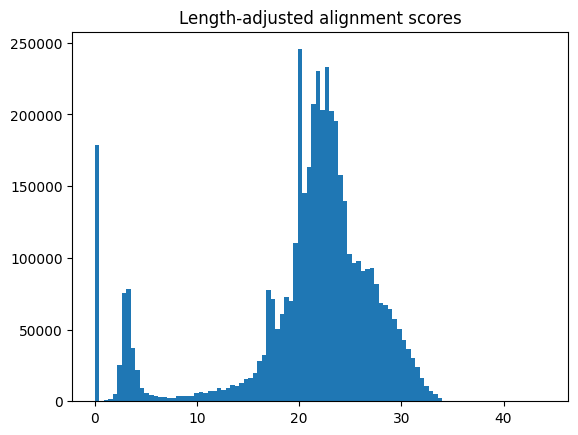

<Figure size 640x480 with 0 Axes>

In [7]:
plt.hist(list(read_score_all.values()), bins=100)
plt.title("Length-adjusted alignment scores")
plt.show()
plt.clf()

## Cross-check BowTie2 results with Jeff’s original validation results.

Exluded reads can be found in `excluded_read_ids.txt`. Let's look at their alignment scores.

In [8]:
excluded_read_id_scores = {}
with open("excluded_read_ids.txt") as inf:
    for line in inf:
        read_id = line.strip()
        alignment_score = read_score_dict[read_id]
        excluded_read_id_scores[read_id] = alignment_score

        

In [72]:
for read_id, alignment_score in excluded_read_id_scores.items():
    if alignment_score > 7:
        print(read_id)

ERR3563089.9818664


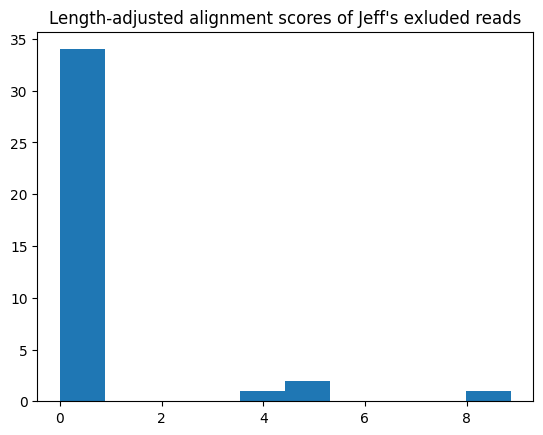

<Figure size 640x480 with 0 Axes>

In [10]:
plt.hist(list(excluded_read_id_scores.values()), bins=10)
plt.title("Length-adjusted alignment scores of Jeff's exluded reads")
plt.show()
plt.clf()

## Check alignment scores of target study reads

In [11]:

target_samples = []
for study in studies:
    if study not in [
        "Brinch 2020",  # unpublished data
        "Crits-Christoph 2021",  # untreated undigested sludge
        "Rothman 2021",
        "Spurbeck 2023",
    ]:
        continue
    
    for bioproject in metadata_papers[study]["projects"]:
        samples = metadata_bioprojects[bioproject]

        if study == "Bengtsson-Palme 2016":
            samples = [
                sample
                for sample in samples
                if metadata_samples[sample]["fine_location"].startswith("Inlet")
            ]

        if study == "Ng 2019":
            samples = [
                sample
                for sample in samples
                if metadata_samples[sample]["fine_location"] == "Influent"
            ]

        # set all samples to strin type
        samples = [str(sample) for sample in samples]
        target_samples.extend(samples)

In [12]:
read_score_dict = {}

sam_target_files = []
missing_samples = set()

hvsams_directory_path = "hvsams"

n_failed_alignments = 0

for filename in os.listdir(hvsams_directory_path):
    if filename.endswith(".sam"):
        sample_id, _, = filename.split(".")
        sample_id = str(sample_id)
        if sample_id not in target_samples:
            missing_samples.add(sample_id)
            continue
        sam_target_files.append(sample_id)
        with open(hvsams_directory_path + "/" + filename) as inf:
            for line in inf:
                if line.startswith("@"):
                    continue
                else:
                    line_split = line.split("\t")

                    read_id = line_split[0]
                    reference_sequence = str(line_split[2])
                    if reference_sequence == "*":
                        alignment_score = 0 # no aligment found
                        read_score_dict[read_id] = alignment_score
                        n_failed_alignments += 1
                        continue
                
                    read_length = len(line_split[9])

                    optional_fields_dict = {}
                    for field in line_split[11:]:
                        key, _, value = field.split(":")
                        optional_fields_dict[key] = value

                    if "AS" in optional_fields_dict:
                        alignment_score = int(optional_fields_dict["AS"])
                        read_score_dict[read_id] = alignment_score / sqrt(read_length)

                    else: # no aligment performed
                        alignment_score = 0
                        n_failed_alignments += 1
                        read_score_dict[read_id] = alignment_score

Some target samples are missing in the SAM files. This happens, because some samples have no human reads; hence they produce no `{sample_id}.hvreads.json`file

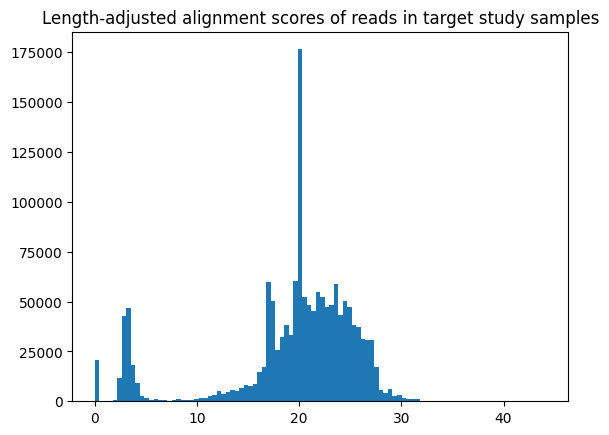

<Figure size 640x480 with 0 Axes>

In [13]:
plt.hist(list(read_score_dict.values()), bins=100)
plt.title("Length-adjusted alignment scores of reads in target study samples")
plt.show()
plt.clf()

In [15]:
reference_read_score = []


hvsams_directory_path = "hvsams"

n_failed_alignments = 0

for filename in os.listdir(hvsams_directory_path):
    if filename.endswith(".sam"):
        sample_id, _, = filename.split(".")
        sample_id = str(sample_id)
        if sample_id not in target_samples:
            missing_samples.add(sample_id)
            continue

        with open(hvsams_directory_path + "/" + filename) as inf:
            for line in inf:
                if line.startswith("@"):
                    continue
                else:
                    line_split = line.split("\t")

                    read_id = line_split[0]
                    reference_sequence = str(line_split[2])



                    if reference_sequence == "*":
                        alignment_score = 0 # no aligment found
                        read_score_dict[read_id] = alignment_score
                        reference_read_score.append([reference_sequence, read_id, alignment_score])
                        
                        continue
                
                    read_length = len(line_split[9])

                    optional_fields_dict = {}
                    for field in line_split[11:]:
                        key, _, value = field.split(":")
                        optional_fields_dict[key] = value

                    if "AS" in optional_fields_dict:
                        alignment_score = int(optional_fields_dict["AS"])
                        length_adj_alignment_score = alignment_score / sqrt(read_length)
                        reference_read_score.append([reference_sequence, read_id, length_adj_alignment_score])

                    else: # no aligment performed
                        alignment_score = 0
                        
                        reference_read_score.append([reference_sequence, read_id, alignment_score])
                        

In [ ]:
refseq_directory_path = "raw-genomes"

refseq_id_and_names = {}

for filename in os.listdir(refseq_directory_path):
    with open(os.path.join(refseq_directory_path, filename)) as inf:
        for line in inf:
            if line.startswith(">"):
                identifier, description = line[1:].split(" ", 1)
                identifier = str(identifier.strip())
                name = description.split(",", 1)[0]
                refseq_id_and_names[identifier] = name.strip()
            else:
                continue

In [20]:
df = pd.DataFrame(reference_read_score, columns =['reference_id', 'read_id', 'alignment_score'])

In [21]:
# add a column with the name of the reference sequence
df['reference_name'] = df['reference_id'].map(refseq_id_and_names)

In [25]:
df[df['reference_id'] == 'NC_045512.2']['read_id']

142          SRR18341114.10472838
143          SRR18341114.10472838
144          SRR18341114.10560687
145          SRR18341114.10560687
146          SRR18341114.10667381
                    ...          
1951178    M_SRR18341119.31579725
1951497    M_SRR18341119.39376495
1951499    M_SRR18341119.39405662
1951764    M_SRR18341119.31010563
1952308    M_SRR18341119.24554728
Name: read_id, Length: 1694955, dtype: object

In [30]:
bad_covid_reads = []
good_covid_reads = []
for reference_id, read_id, score in reference_read_score:
    if reference_id == 'NC_045512.2':
        if score < 7:
            bad_covid_reads.append(read_id)
        else:    
            good_covid_reads.append(read_id)

In [33]:
print(len(bad_covid_reads))
print(len(good_covid_reads))


print(len(reference_read_score))

148737
1546218
1952373


In [ ]:
print(sorted_count_below_8)

{'Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1': 150745, 'No Alignment': 28812, 'Astrovirus MLB1': 4016, 'Macacine herpesvirus 1': 2139, 'Influenza A virus (A/Puerto Rico/8/1934(H1N1)) segment 6': 1384, 'Human coronavirus OC43 strain ATCC VR-759': 1229, 'Norovirus GII': 968, 'Human bocavirus 2c PK isolate PK-5510': 820, 'SARS coronavirus Tor2': 517, 'Astrovirus MLB2': 504, 'Norovirus GII.2 strain Env/CHN/2016/GII.P16-GII.2/BJSMQ': 500, 'Macacine alphaherpesvirus 1 isolate KQ': 325, 'Human adenovirus C': 316, 'Human adenovirus type 1': 308, 'Human adenovirus F': 297, 'Human adenovirus 5': 291, 'Encephalomyocarditis virus': 274, 'Human bocavirus 3': 264, 'Papiine herpesvirus 2': 247, 'Human adenovirus E': 237, 'Human feces pecovirus strain PeCV-NI': 220, 'Norovirus GII.17': 220, 'Human bocavirus 4 NI strain HBoV4-NI-385': 220, 'Hudisavirus sp. isolate P22': 182, 'Human immunodeficiency virus 2': 175, 'Astrovirus MLB3 isolate MLB3/human/Vellore/26564/2004': 174, 'Nor

In [ ]:
# Replace keys in count_below_8 with names

